# Time series forecating BitPredict

## Get data

Data downloaded from: https://www.coindesk.com/price/bitcoin/

### Witn Python

In [1]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/drive/MyDrive/Data/BTC_USD_2014-11-04_2022-02-15-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0),
  datetime.datetime(2014, 11, 13, 0, 0)],
 [324.467934,
  328.644408,
  337.921358,
  348.99286,
  341.459753,
  344.745289,
  357.239982,
  371.116917,
  366.664633,
  428.882925])

### With Pandas

In [2]:
# Create DataFrame 
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Data/BTC_USD_2014-11-04_2022-02-15-CoinDesk.csv",
                parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column 
          

In [3]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2661 entries, 2014-11-04 to 2022-02-15
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2661 non-null   object 
 1   Closing Price (USD)  2661 non-null   float64
 2   24h Open (USD)       2661 non-null   float64
 3   24h High (USD)       2661 non-null   float64
 4   24h Low (USD)        2661 non-null   float64
dtypes: float64(4), object(1)
memory usage: 124.7+ KB


In [5]:
len(df)

2661

In [6]:
# Create DataFrame only with price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
...,...
2022-02-11,43522.241370
2022-02-12,42394.145450
2022-02-13,42233.713050


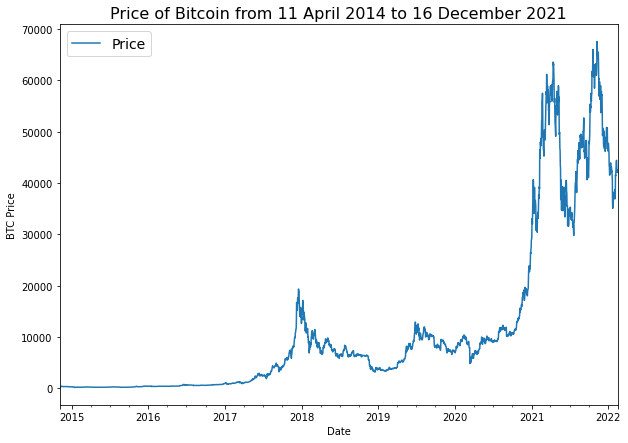

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7));
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 11 April 2014 to 16 December 2021", fontsize=16)
plt.legend(fontsize=14);

##  Format data part 1: Create train and test sets for time series 

In [8]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000',
        '2014-11-12T00:00:00.000000000', '2014-11-13T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
        344.745289, 357.239982, 371.116917, 366.664633, 428.882925]))

In [9]:
# Create train and test splits 
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits 
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2128, 533, 2128, 533)

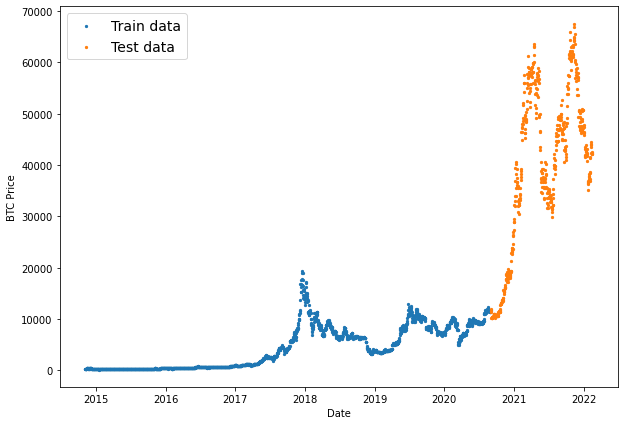

In [10]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Function: Time Series PLot

In [11]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  PLots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plotthe series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

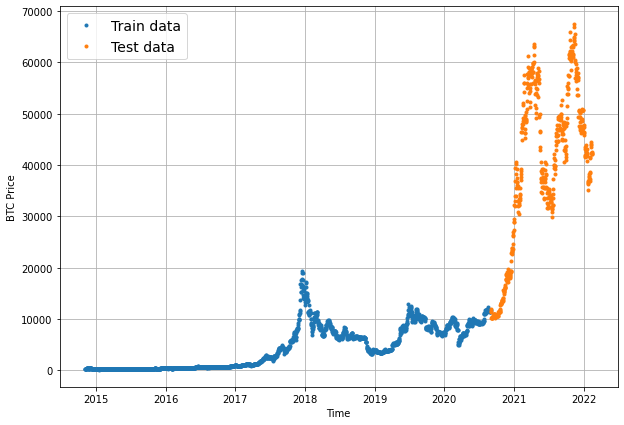

In [12]:
# Plot function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

* **Horizon** - number of timesteps into the future we're going to predict
* **Window size** - number of timesteps we're going to use to predict **horizon**

* 0	Naïve model (baseline)	
* 1	Dense model, horizon=1, window=7
* 2	Same as 1, horizon=1, window=30	
* 3	Same as 1, horizon=7, window=30	
* 4	Conv1D
* 5	LSTM	
* 6	Same as 1 (but with multivariate data)	
* 7	N-BEATs Algorithm	
* 8	Ensemble (multiple models optimized on different loss functions)	
* 9	Future prediction model (model to predict future values)	
* 10	Same as 1 (but with turkey  data introduced)

## Model 0: Naive forecast (baseline)
The formula:  

$$\hat{y}_{t} = y_{t-1}$$

In [13]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([11656.432744, 11923.96    , 11396.857033, 10176.247978,
        10464.      , 10161.158957, 10255.030965, 10373.5     ,
        10123.3     , 10227.244121]),
 array([41586.856262, 41420.436241, 42414.080523, 43861.85    ,
        44074.346549, 44421.009164, 43522.24137 , 42394.14545 ,
        42233.71305 , 42067.755487]))

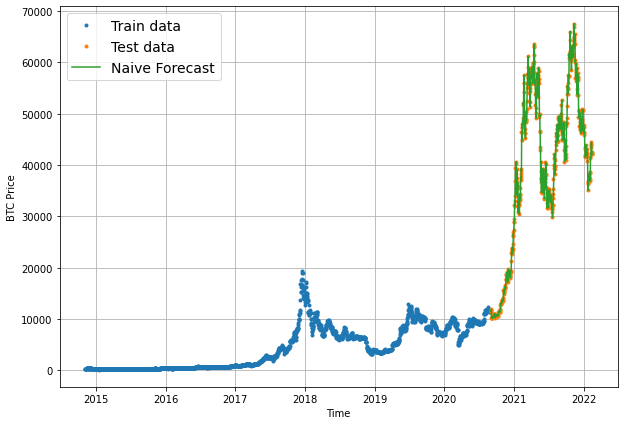

In [14]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")


## Evaluating
Metrics:
* MAE - mean absolute error
* MSE- mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

In [15]:
import tensorflow as tf

In [16]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)

  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [17]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9985604023354936

## Function: Metrics

In [18]:
# Create a function to evaluate with various metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [19]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

## Format Data Part 2: Windowing dataset

Window time series dataset to turn data into a supervised learning problem

In [20]:
# Setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of BitcoinPredict to make predictions

In [21]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.
  
  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [22]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


Function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple window steps, for example:

````
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]

````
3. Uses the 2D array multiplw window steps (from 2.) to index on a target series (Bitcoin)
4. Uses `get_labelled_windows()` function to turn the window steps into windows with a specified horizon

**Resource:** https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

## Function: Make window

In [23]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array of sequential labelled windows_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of window
  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels 



In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE,  horizon=HORIZON)
len(full_windows), len(full_labels)

(2654, 2654)

In [25]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] -> Label: [371.116917]
Window: [328.644408 337.921358 348.99286  341.459753 344.745289 357.239982
 371.116917] -> Label: [366.664633]
Window: [337.921358 348.99286  341.459753 344.745289 357.239982 371.116917
 366.664633] -> Label: [428.882925]


## Turning windows into trainning and test sets 
## Function: Make train test split

In [26]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [27]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2123, 531, 2123, 531)

In [28]:
train_windows[:5], train_labels[:5]

(array([[324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
         344.745289, 357.239982],
        [328.644408, 337.921358, 348.99286 , 341.459753, 344.745289,
         357.239982, 371.116917],
        [337.921358, 348.99286 , 341.459753, 344.745289, 357.239982,
         371.116917, 366.664633],
        [348.99286 , 341.459753, 344.745289, 357.239982, 371.116917,
         366.664633, 428.882925],
        [341.459753, 344.745289, 357.239982, 371.116917, 366.664633,
         428.882925, 418.944218]]), array([[371.116917],
        [366.664633],
        [428.882925],
        [418.944218],
        [399.688315]]))

## Make a modelling checkpoint

Model's performance will fluctuate from experiment to experiment, write a model to compare models.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint


In [29]:
import os
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

* A single dense layer with 128 hidden units and ReLU  
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function 
* Batch size of 128 
* 100 epochs

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1 Make a model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # same as no activation
], name="model_1_dense") # for save

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])
# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
17/17 [==============================] - 4s 51ms/step - loss: 1079.9799 - mae: 1079.9799 - mse: 3352841.0000 - val_loss: 5143.3218 - val_mae: 5143.3218 - val_mse: 39074376.0000
Epoch 2/100
17/17 [==============================] - 0s 28ms/step - loss: 339.6500 - mae: 339.6500 - mse: 365530.7500 - val_loss: 1932.7058 - val_mae: 1932.7058 - val_mse: 6949769.0000
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 242.9498 - mae: 242.9498 - mse: 226358.1406 - val_loss: 1921.2261 - val_mae: 1921.2261 - val_mse: 6696955.5000
Epoch 4/100
17/17 [==============================] - 0s 26ms/step - loss: 222.7527 - mae: 222.7527 - mse: 201720.2969 - val_loss: 1878.4476 - val_mae: 1878.4476 - val_mse: 6670113.5000
Epoch 5/100
17/17 [==============================] - 0s 27ms/step - loss: 216.8366 - mae: 216.8366 - mse: 190239.8594 - val_loss: 1830.7319 - val_mae: 1830.7319 - val_mse: 6150041.0000
Epoch 6/100
17/17 [==============================] - 0s 27ms/step - los

In [31]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1154.8875 - mae: 1154.8875 - mse: 2796122.0000


[1154.887451171875, 1154.887451171875, 2796122.0]

In [32]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1154.8875 - mae: 1154.8875 - mse: 2796122.0000


[1154.887451171875, 1154.887451171875, 2796122.0]

## Making forecast with a model (on the dataset)

1. Take in a train model
2. Takes in some inout data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions


In [33]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [34]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(531, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([11897.754 , 11469.822 , 10358.911 , 10331.596 , 10189.902 ,
        10210.107 , 10292.4375, 10216.044 , 10175.36  , 10329.493 ],
       dtype=float32)>)

In [35]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

In [36]:
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

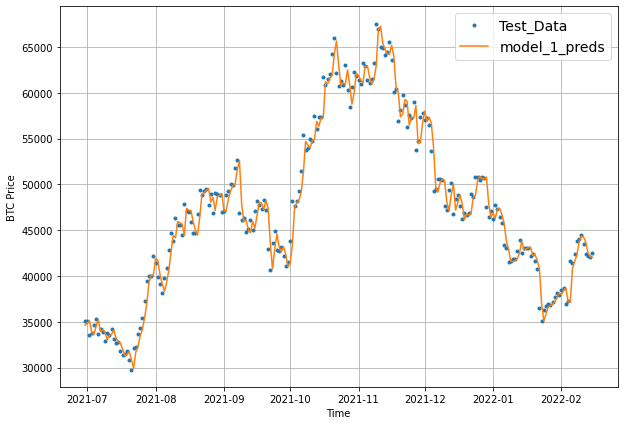

In [37]:
import matplotlib.pyplot as plt
# Let's plot model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_Data");
plot_time_series(timesteps=X_test[-len(test_windows):], 
                  values=model_1_preds, 
                  start=offset, 
                  format="-",
                  label="model_1_preds");

## Model 2: Dense (window=30, horizon=1)


In [38]:
HORIZON = 1
WINDOW_SIZE = 30

In [39]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2631, 2631)

In [40]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2104, 527, 2104, 527)

In [41]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

# Compile 
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [42]:
# Evaluate model
model_2.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1288.8793


1288.8792724609375

In [43]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1250.6849


1250.6849365234375

In [44]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [45]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1250.6849,
 'mape': 3.058493,
 'mase': 1.0886295,
 'mse': 3150322.0,
 'rmse': 1774.9147}

In [46]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

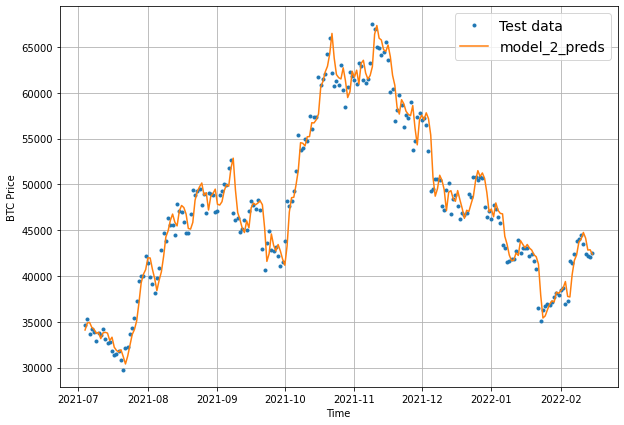

In [47]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_windows offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-",  label="model_2_preds")

## Model 3: Dense (window =30, horizon =7)

In [48]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2625, 2625)

In [49]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_label)

(2100, 525, 2100, 1)

In [50]:
tf.random.set_seed(42)

# Create model 
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

# Compile 
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())
# Fit 
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [51]:
# Evaluate
model_3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 2496.9639


2496.9638671875

In [52]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 2465.8230


2465.822998046875

In [53]:
# Make prediciotns with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

In [54]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=tf.squeeze(model_3_preds))

## Function: Evaluation Preds for larger horizons

In [55]:
# Create a function to evaluate with various metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  
  # Remove dimension 
  y_true = tf.squeeze(y_true)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce dimensions)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mape = tf.reduce_mean(mase)
  

  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [56]:
# Get model_3 results
model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_3_preds)
model_3_results

{'mae': 2465.8232,
 'mape': 2.1418667,
 'mase': 2.1418667,
 'mse': 12047559.0,
 'rmse': 2819.5027}

In [57]:
model_2_results

{'mae': 1250.6849,
 'mape': 3.058493,
 'mase': 1.0886295,
 'mse': 3150322.0,
 'rmse': 1774.9147}

In [58]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

In [59]:
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

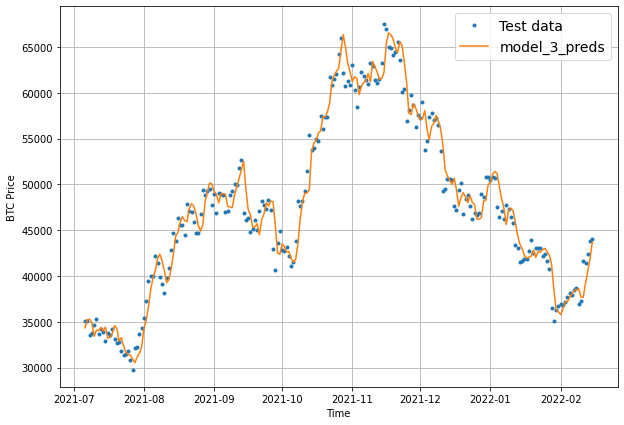

In [60]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset,format="-", label="model_3_preds")

## Which of models is performing the best so far?

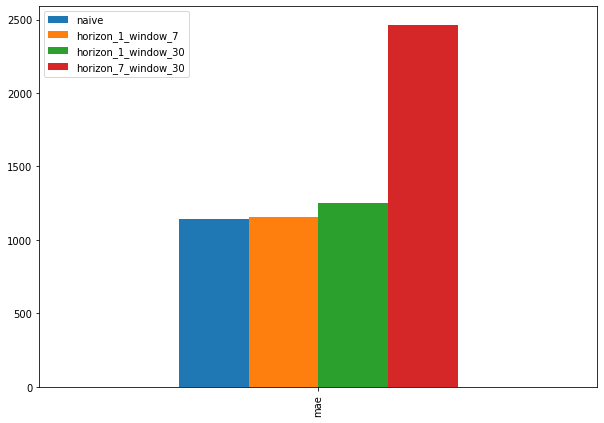

In [61]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4: Con1D

In [62]:
HORIZON = 1
WINDOW_SIZE = 7 

In [63]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2654, 2654)

In [64]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels) 

(2123, 2123, 531, 531)

In [65]:
# Turn data into a tensor
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982])>

In [66]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [67]:
# Test out lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[324.46793]
 [328.6444 ]
 [337.92136]
 [348.99286]
 [341.45975]
 [344.7453 ]
 [357.24   ]]


In [68]:
# Create Conv1D

tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [69]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


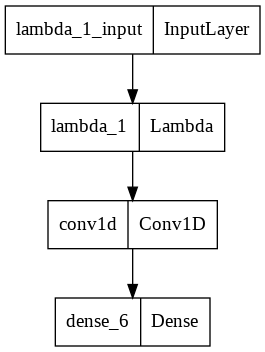

In [70]:
tf.keras.utils.plot_model(model_4)

In [71]:
model_4.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 1169.4218


1169.4217529296875

In [72]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 3ms/step - loss: 1160.3584


1160.3583984375

In [73]:
model_4_preds = make_preds(model_4, test_windows)

In [74]:
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([11881.267 , 11526.384 , 10471.792 , 10400.905 , 10217.148 ,
       10215.236 , 10332.831 , 10197.083 , 10194.6045, 10315.895 ],
      dtype=float32)>

In [75]:
model_4_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_4_preds)
model_4_results

{'mae': 1160.3584,
 'mape': 2.881158,
 'mase': 1.0144892,
 'mse': 2824260.5,
 'rmse': 1680.5536}

In [76]:
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

In [77]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

## Model 5: RNN(LSTM)

In [78]:
tf.random.set_seed(42)

# Let's build an LSTM  modle with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128,activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

# Compile 
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows, 
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
11/17 [==================>...........] - ETA: 0s - loss: 3538.6899 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 3s 113ms/step - loss: 3309.2681 - val_loss: 20350.9980
Epoch 2/100
10/17 [================>.............] - ETA: 0s - loss: 1774.4017INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 117ms/step - loss: 1351.1233 - val_loss: 2387.7327
Epoch 3/100
14/17 [=======================>......] - ETA: 0s - loss: 349.4309INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 104ms/step - loss: 335.3099 - val_loss: 1912.5780
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 243.3379 - val_loss: 1970.2170
Epoch 5/100
17/17 [==============================] - 0s 7ms/step - loss: 226.4278 - val_loss: 1932.7240
Epoch 6/100
11/17 [==================>...........] - ETA: 0s - loss: 218.4156INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 220.6794 - val_loss: 1886.7706
Epoch 7/100
11/17 [==================>...........] - ETA: 0s - loss: 209.5904INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 99ms/step - loss: 219.1491 - val_loss: 1878.3120
Epoch 8/100
12/17 [====================>.........] - ETA: 0s - loss: 221.4645INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 122ms/step - loss: 218.0716 - val_loss: 1863.8898
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 216.4355 - val_loss: 1868.3088
Epoch 10/100
12/17 [====================>.........] - ETA: 0s - loss: 220.5772INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 99ms/step - loss: 216.2279 - val_loss: 1835.0280
Epoch 11/100
11/17 [==================>...........] - ETA: 0s - loss: 218.1941INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 99ms/step - loss: 215.4984 - val_loss: 1831.2465
Epoch 12/100
11/17 [==================>...........] - ETA: 0s - loss: 213.7759INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 116ms/step - loss: 212.5469 - val_loss: 1817.1727
Epoch 13/100
10/17 [================>.............] - ETA: 0s - loss: 212.8599INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 102ms/step - loss: 211.6414 - val_loss: 1796.1913
Epoch 14/100
17/17 [==============================] - 0s 7ms/step - loss: 209.1928 - val_loss: 1799.7922
Epoch 15/100
12/17 [====================>.........] - ETA: 0s - loss: 207.4852INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 209.9921 - val_loss: 1769.8113
Epoch 16/100
11/17 [==================>...........] - ETA: 0s - loss: 221.7460INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 99ms/step - loss: 206.7347 - val_loss: 1761.8115
Epoch 17/100
11/17 [==================>...........] - ETA: 0s - loss: 206.2927INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 120ms/step - loss: 205.0648 - val_loss: 1747.3420
Epoch 18/100
11/17 [==================>...........] - ETA: 0s - loss: 207.2910INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 200.7749 - val_loss: 1741.7930
Epoch 19/100
11/17 [==================>...........] - ETA: 0s - loss: 200.8919INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 102ms/step - loss: 199.8167 - val_loss: 1662.3037
Epoch 20/100
17/17 [==============================] - 0s 7ms/step - loss: 210.8692 - val_loss: 1972.2385
Epoch 21/100
17/17 [==============================] - 0s 7ms/step - loss: 201.7361 - val_loss: 1697.6595
Epoch 22/100
17/17 [==============================] - 0s 7ms/step - loss: 194.5424 - val_loss: 1669.3020
Epoch 23/100
11/17 [==================>...........] - ETA: 0s - loss: 191.4213INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 192.7477 - val_loss: 1654.7092
Epoch 24/100
12/17 [====================>.........] - ETA: 0s - loss: 190.7324INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 152ms/step - loss: 190.4295 - val_loss: 1651.1790
Epoch 25/100
13/17 [=====================>........] - ETA: 0s - loss: 186.7814INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 132ms/step - loss: 189.1746 - val_loss: 1621.8174
Epoch 26/100
11/17 [==================>...........] - ETA: 0s - loss: 182.4970INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 186.9421 - val_loss: 1612.1968
Epoch 27/100
11/17 [==================>...........] - ETA: 0s - loss: 183.5651INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 117ms/step - loss: 184.7830 - val_loss: 1599.9830
Epoch 28/100
11/17 [==================>...........] - ETA: 0s - loss: 184.0237INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 184.0742 - val_loss: 1574.9624
Epoch 29/100
11/17 [==================>...........] - ETA: 0s - loss: 183.2197INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 181.7392 - val_loss: 1567.3049
Epoch 30/100
10/17 [================>.............] - ETA: 0s - loss: 171.1631INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 179.3147 - val_loss: 1555.1896
Epoch 31/100
11/17 [==================>...........] - ETA: 0s - loss: 180.4547INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 120ms/step - loss: 177.9034 - val_loss: 1529.7330
Epoch 32/100
17/17 [==============================] - 0s 7ms/step - loss: 176.3687 - val_loss: 1575.7716
Epoch 33/100
12/17 [====================>.........] - ETA: 0s - loss: 176.4011INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 176.6784 - val_loss: 1500.8346
Epoch 34/100
17/17 [==============================] - 0s 7ms/step - loss: 172.0625 - val_loss: 1527.8684
Epoch 35/100
12/17 [====================>.........] - ETA: 0s - loss: 173.6560INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 173.8864 - val_loss: 1470.8635
Epoch 36/100
17/17 [==============================] - 0s 7ms/step - loss: 167.7254 - val_loss: 1481.4119
Epoch 37/100
 9/17 [==============>...............] - ETA: 0s - loss: 173.1986INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 167.4543 - val_loss: 1443.7949
Epoch 38/100
11/17 [==================>...........] - ETA: 0s - loss: 168.1770INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 119ms/step - loss: 164.6839 - val_loss: 1432.4124
Epoch 39/100
11/17 [==================>...........] - ETA: 0s - loss: 155.8307INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 106ms/step - loss: 163.4187 - val_loss: 1419.4391
Epoch 40/100
17/17 [==============================] - 0s 7ms/step - loss: 162.8294 - val_loss: 1428.0215
Epoch 41/100
12/17 [====================>.........] - ETA: 0s - loss: 161.4971INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 98ms/step - loss: 162.6913 - val_loss: 1403.0009
Epoch 42/100
11/17 [==================>...........] - ETA: 0s - loss: 161.1223INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 116ms/step - loss: 159.6554 - val_loss: 1398.1952
Epoch 43/100
12/17 [====================>.........] - ETA: 0s - loss: 164.3027INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 159.0216 - val_loss: 1398.0614
Epoch 44/100
12/17 [====================>.........] - ETA: 0s - loss: 162.2659INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 102ms/step - loss: 157.5995 - val_loss: 1376.9362
Epoch 45/100
12/17 [====================>.........] - ETA: 0s - loss: 156.7664INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 155.7925 - val_loss: 1363.9097
Epoch 46/100
17/17 [==============================] - 0s 7ms/step - loss: 155.8276 - val_loss: 1372.4559
Epoch 47/100
12/17 [====================>.........] - ETA: 0s - loss: 162.1944INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 118ms/step - loss: 154.8695 - val_loss: 1346.1727
Epoch 48/100
17/17 [==============================] - 0s 7ms/step - loss: 154.5861 - val_loss: 1347.3201
Epoch 49/100
17/17 [==============================] - 0s 7ms/step - loss: 157.4447 - val_loss: 1529.3845
Epoch 50/100
11/17 [==================>...........] - ETA: 0s - loss: 169.4727INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 99ms/step - loss: 165.0975 - val_loss: 1332.8092
Epoch 51/100
11/17 [==================>...........] - ETA: 0s - loss: 151.2050INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 155.8610 - val_loss: 1322.5131
Epoch 52/100
17/17 [==============================] - 0s 8ms/step - loss: 156.8884 - val_loss: 1324.8730
Epoch 53/100
17/17 [==============================] - 0s 7ms/step - loss: 152.0406 - val_loss: 1323.0740
Epoch 54/100
12/17 [====================>.........] - ETA: 0s - loss: 149.6166INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 116ms/step - loss: 151.5245 - val_loss: 1313.6326
Epoch 55/100
12/17 [====================>.........] - ETA: 0s - loss: 145.3745INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 149.4326 - val_loss: 1302.0294
Epoch 56/100
17/17 [==============================] - 0s 7ms/step - loss: 150.4925 - val_loss: 1305.5560
Epoch 57/100
11/17 [==================>...........] - ETA: 0s - loss: 149.2825INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 148.1130 - val_loss: 1293.8599
Epoch 58/100
17/17 [==============================] - 0s 7ms/step - loss: 152.3731 - val_loss: 1308.0565
Epoch 59/100
17/17 [==============================] - 0s 8ms/step - loss: 148.9382 - val_loss: 1326.0795
Epoch 60/100
11/17 [==================>...........] - ETA: 0s - loss: 156.6182INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 122ms/step - loss: 146.7185 - val_loss: 1287.3685
Epoch 61/100
17/17 [==============================] - 0s 7ms/step - loss: 147.2045 - val_loss: 1318.2488
Epoch 62/100
17/17 [==============================] - 0s 8ms/step - loss: 148.4557 - val_loss: 1350.2625
Epoch 63/100
11/17 [==================>...........] - ETA: 0s - loss: 148.5270INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 147.9849 - val_loss: 1283.1971
Epoch 64/100
11/17 [==================>...........] - ETA: 0s - loss: 146.1482INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 102ms/step - loss: 146.1007 - val_loss: 1274.7137
Epoch 65/100
11/17 [==================>...........] - ETA: 0s - loss: 143.2630INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 102ms/step - loss: 145.5075 - val_loss: 1274.4056
Epoch 66/100
11/17 [==================>...........] - ETA: 0s - loss: 141.1803INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 121ms/step - loss: 147.0532 - val_loss: 1271.4724
Epoch 67/100
11/17 [==================>...........] - ETA: 0s - loss: 147.0010INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 144.5268 - val_loss: 1265.2476
Epoch 68/100
17/17 [==============================] - 0s 7ms/step - loss: 144.7058 - val_loss: 1310.6284
Epoch 69/100
17/17 [==============================] - 0s 8ms/step - loss: 147.1363 - val_loss: 1271.0869
Epoch 70/100
12/17 [====================>.........] - ETA: 0s - loss: 143.3096INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 103ms/step - loss: 144.2249 - val_loss: 1256.8796
Epoch 71/100
12/17 [====================>.........] - ETA: 0s - loss: 144.2441INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 102ms/step - loss: 144.1778 - val_loss: 1254.6605
Epoch 72/100
17/17 [==============================] - 0s 7ms/step - loss: 149.7566 - val_loss: 1268.1555
Epoch 73/100
17/17 [==============================] - 0s 7ms/step - loss: 145.4208 - val_loss: 1267.4836
Epoch 74/100
12/17 [====================>.........] - ETA: 0s - loss: 144.0730INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 119ms/step - loss: 144.7380 - val_loss: 1254.0778
Epoch 75/100
17/17 [==============================] - 0s 7ms/step - loss: 144.1044 - val_loss: 1301.6464
Epoch 76/100
17/17 [==============================] - 0s 7ms/step - loss: 145.7893 - val_loss: 1269.1038
Epoch 77/100
17/17 [==============================] - 0s 7ms/step - loss: 145.1064 - val_loss: 1331.3522
Epoch 78/100
12/17 [====================>.........] - ETA: 0s - loss: 144.8799INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 103ms/step - loss: 148.2825 - val_loss: 1244.1016
Epoch 79/100
12/17 [====================>.........] - ETA: 0s - loss: 138.2296INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 142.4068 - val_loss: 1241.6288
Epoch 80/100
17/17 [==============================] - 0s 8ms/step - loss: 142.7423 - val_loss: 1244.6337
Epoch 81/100
11/17 [==================>...........] - ETA: 0s - loss: 140.7377INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 117ms/step - loss: 142.9311 - val_loss: 1238.4376
Epoch 82/100
17/17 [==============================] - 0s 7ms/step - loss: 141.6313 - val_loss: 1239.8573
Epoch 83/100
12/17 [====================>.........] - ETA: 0s - loss: 138.1857INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 99ms/step - loss: 141.5896 - val_loss: 1235.7845
Epoch 84/100
12/17 [====================>.........] - ETA: 0s - loss: 135.8891INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 142.0850 - val_loss: 1234.7207
Epoch 85/100
17/17 [==============================] - 0s 7ms/step - loss: 146.9481 - val_loss: 1294.7410
Epoch 86/100
11/17 [==================>...........] - ETA: 0s - loss: 141.0195INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 101ms/step - loss: 144.9551 - val_loss: 1234.3790
Epoch 87/100
11/17 [==================>...........] - ETA: 0s - loss: 140.6726INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 120ms/step - loss: 141.4015 - val_loss: 1233.3098
Epoch 88/100
17/17 [==============================] - 0s 7ms/step - loss: 141.0474 - val_loss: 1234.4987
Epoch 89/100
17/17 [==============================] - 0s 8ms/step - loss: 140.4824 - val_loss: 1238.0288
Epoch 90/100
17/17 [==============================] - 0s 8ms/step - loss: 140.5594 - val_loss: 1245.2755
Epoch 91/100
17/17 [==============================] - 0s 7ms/step - loss: 140.0512 - val_loss: 1262.2516
Epoch 92/100
12/17 [====================>.........] - ETA: 0s - loss: 142.9005INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 103ms/step - loss: 140.1651 - val_loss: 1222.6523
Epoch 93/100
17/17 [==============================] - 0s 9ms/step - loss: 140.2390 - val_loss: 1236.1238
Epoch 94/100
17/17 [==============================] - 0s 7ms/step - loss: 142.1473 - val_loss: 1222.8926
Epoch 95/100
11/17 [==================>...........] - ETA: 0s - loss: 145.0716INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


17/17 [==============================] - 2s 100ms/step - loss: 140.2457 - val_loss: 1221.0577
Epoch 96/100
17/17 [==============================] - 0s 7ms/step - loss: 140.9059 - val_loss: 1251.5222
Epoch 97/100
17/17 [==============================] - 0s 7ms/step - loss: 140.4044 - val_loss: 1223.0576
Epoch 98/100
17/17 [==============================] - 0s 7ms/step - loss: 140.9058 - val_loss: 1309.7788
Epoch 99/100
17/17 [==============================] - 0s 7ms/step - loss: 141.9459 - val_loss: 1226.9421
Epoch 100/100
17/17 [==============================] - 0s 6ms/step - loss: 141.3257 - val_loss: 1267.2878


In [79]:
# Load in the best version of mdoel_5 and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1221.0576


1221.0576171875

In [80]:
# Make prediction 
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([11870.565, 11586.113, 10625.466, 10329.201, 10218.763],
      dtype=float32)>

In [81]:
# evaluate model_5 predictions
model_5_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_5_preds)

In [82]:
model_5_results

{'mae': 1221.0576,
 'mape': 3.0289469,
 'mase': 1.0675578,
 'mse': 3001661.8,
 'rmse': 1732.5304}

In [83]:
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

In [84]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

In [85]:
bitcoin_prices.head()

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753


## Make a multivariate time series dataset

Add new one feature to improve results

Bitcoin halving event was choosed for new one

Ref.: https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving



In [86]:
# Let's add the bitcoin halving events to dataset
block_reward_1 = 50  # 11 april 2009 - this block reward isn't in dataset
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020
# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [87]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(613, 2022)

In [88]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

In [89]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-04,324.467934,None
2014-11-05,328.644408,None
2014-11-06,337.921358,None
2014-11-07,348.992860,None
2014-11-08,341.459753,None


In [90]:
# Add in block_reward values as a feature to dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [91]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-04,324.467934,25
2014-11-05,328.644408,25
2014-11-06,337.921358,25
2014-11-07,348.992860,25
2014-11-08,341.459753,25


In [92]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2022-02-11,43522.241370,6.25
2022-02-12,42394.145450,6.25
2022-02-13,42233.713050,6.25
2022-02-14,42067.755487,6.25
2022-02-15,42554.261521,6.25


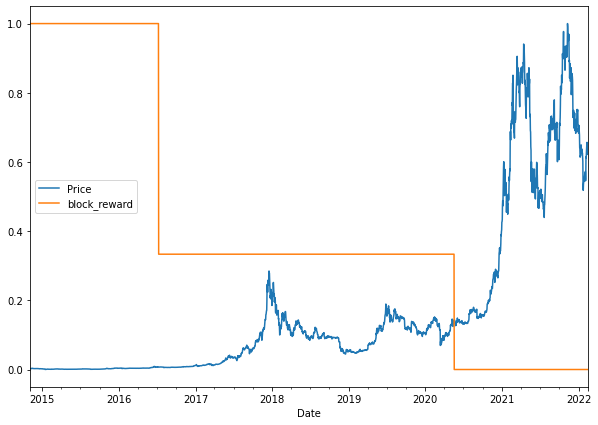

In [93]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                        columns=bitcoin_prices_block.columns,
                                                                        index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7)); 

## Making a windowed dataset with dataset

In [94]:
HORIZON = 1
WINDOW = 7 

In [95]:
# Make a copy of the data
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW):
  bitcoin_prices_windowed[f"Prices+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1) 
bitcoin_prices_windowed.head(10)

,Price,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,,
2014-11-04,324.467934,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,25,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,25,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,25,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,25,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
2014-11-09,344.745289,25,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
2014-11-10,357.239982,25,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
2014-11-11,371.116917,25,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
2014-11-12,366.664633,25,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408


In [96]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis =1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"]
X.head()

,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2014-11-11,25.0,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409,324.467926
2014-11-12,25.0,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356,328.644409
2014-11-13,25.0,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859,337.921356
2014-11-14,25.0,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747,348.992859
2014-11-15,25.0,418.944214,428.882935,366.664642,371.116913,357.239990,344.745300,341.459747


In [97]:
y.head()

Date
2014-11-11    371.116917
2014-11-12    366.664633
2014-11-13    428.882925
2014-11-14    418.944218
2014-11-15    399.688315
Name: Price, dtype: float64

In [98]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2123, 2123, 531, 531)

## Model 6 Dense (multivariate time series) 

In [99]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name = "model_6_multivariate")

#Compile
model_6.compile(loss="mae", 
                optimizer=tf.keras.optimizers.Adam())

#Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/17 [>.............................] - ETA: 4s - loss: 2906.0938INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 1s 31ms/step - loss: 1777.6896 - val_loss: 3301.6362
Epoch 2/100
 1/17 [>.............................] - ETA: 0s - loss: 416.4508INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 25ms/step - loss: 440.6947 - val_loss: 3228.5918
Epoch 3/100
 1/17 [>.............................] - ETA: 0s - loss: 327.8310INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 306.2547 - val_loss: 2262.1609
Epoch 4/100
 1/17 [>.............................] - ETA: 0s - loss: 352.9631INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 28ms/step - loss: 268.3079 - val_loss: 2207.4648
Epoch 5/100
 1/17 [>.............................] - ETA: 0s - loss: 183.9990INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 252.3781 - val_loss: 2117.7200
Epoch 6/100
 1/17 [>.............................] - ETA: 0s - loss: 219.0747INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 25ms/step - loss: 245.5573 - val_loss: 2061.6970
Epoch 7/100
 1/17 [>.............................] - ETA: 0s - loss: 265.1410INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 239.7949 - val_loss: 2016.7227
Epoch 8/100
 1/17 [>.............................] - ETA: 0s - loss: 244.4878INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 25ms/step - loss: 236.7004 - val_loss: 1978.9668
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 229.3811 - val_loss: 1979.1412
Epoch 10/100
 1/17 [>.............................] - ETA: 0s - loss: 237.5542INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 227.9454 - val_loss: 1967.2347
Epoch 11/100
 1/17 [>.............................] - ETA: 0s - loss: 219.6486INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 224.4259 - val_loss: 1804.3165
Epoch 12/100
 1/17 [>.............................] - ETA: 0s - loss: 238.5446INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 215.2296 - val_loss: 1719.1323
Epoch 13/100
 1/17 [>.............................] - ETA: 0s - loss: 226.6050INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 200.9898 - val_loss: 1654.6892
Epoch 14/100
 1/17 [>.............................] - ETA: 0s - loss: 153.4158INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 191.4280 - val_loss: 1621.6168
Epoch 15/100
 1/17 [>.............................] - ETA: 0s - loss: 160.3976INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 185.6024 - val_loss: 1554.1102
Epoch 16/100
 1/17 [>.............................] - ETA: 0s - loss: 186.5485INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 178.5260 - val_loss: 1506.3602
Epoch 17/100
 1/17 [>.............................] - ETA: 0s - loss: 120.1073INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 173.5481 - val_loss: 1466.0885
Epoch 18/100
 1/17 [>.............................] - ETA: 0s - loss: 172.1846INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 168.6322 - val_loss: 1440.9020
Epoch 19/100
 1/17 [>.............................] - ETA: 0s - loss: 180.3050INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 168.7408 - val_loss: 1400.7976
Epoch 20/100
17/17 [==============================] - 0s 5ms/step - loss: 162.6387 - val_loss: 1416.6327
Epoch 21/100
 1/17 [>.............................] - ETA: 0s - loss: 194.8830INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 1s 42ms/step - loss: 164.6966 - val_loss: 1354.7617
Epoch 22/100
 1/17 [>.............................] - ETA: 0s - loss: 161.2891INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 161.2445 - val_loss: 1332.6472
Epoch 23/100
17/17 [==============================] - ETA: 0s - loss: 152.9624INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 152.9624 - val_loss: 1317.0873
Epoch 24/100
 1/17 [>.............................] - ETA: 0s - loss: 134.4451INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 152.8705 - val_loss: 1310.1033
Epoch 25/100
 1/17 [>.............................] - ETA: 0s - loss: 147.6726INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 150.2231 - val_loss: 1307.4067
Epoch 26/100
 1/17 [>.............................] - ETA: 0s - loss: 131.7877INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 150.3129 - val_loss: 1290.3336
Epoch 27/100
17/17 [==============================] - 0s 5ms/step - loss: 149.0480 - val_loss: 1322.3662
Epoch 28/100
 1/17 [>.............................] - ETA: 0s - loss: 156.5069INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 148.1313 - val_loss: 1264.7360
Epoch 29/100
17/17 [==============================] - 0s 4ms/step - loss: 146.1781 - val_loss: 1272.8931
Epoch 30/100
 1/17 [>.............................] - ETA: 0s - loss: 130.0125INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 153.4888 - val_loss: 1245.0039
Epoch 31/100
17/17 [==============================] - 0s 5ms/step - loss: 143.5736 - val_loss: 1253.7316
Epoch 32/100
17/17 [==============================] - 0s 4ms/step - loss: 142.0430 - val_loss: 1299.8324
Epoch 33/100
 1/17 [>.............................] - ETA: 0s - loss: 165.7167INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 144.9845 - val_loss: 1236.6350
Epoch 34/100
17/17 [==============================] - 0s 5ms/step - loss: 143.6417 - val_loss: 1302.9490
Epoch 35/100
 1/17 [>.............................] - ETA: 0s - loss: 162.6477INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 150.3753 - val_loss: 1220.6068
Epoch 36/100
17/17 [==============================] - 0s 5ms/step - loss: 147.9597 - val_loss: 1253.6323
Epoch 37/100
17/17 [==============================] - 0s 4ms/step - loss: 148.1373 - val_loss: 1384.3101
Epoch 38/100
 1/17 [>.............................] - ETA: 0s - loss: 184.3453INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 147.6814 - val_loss: 1212.4301
Epoch 39/100
 1/17 [>.............................] - ETA: 0s - loss: 165.3878INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 139.3244 - val_loss: 1205.3777
Epoch 40/100
17/17 [==============================] - 0s 5ms/step - loss: 139.3431 - val_loss: 1281.5873
Epoch 41/100
17/17 [==============================] - 0s 4ms/step - loss: 140.7449 - val_loss: 1225.1382
Epoch 42/100
 1/17 [>.............................] - ETA: 0s - loss: 169.8760INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 25ms/step - loss: 139.6306 - val_loss: 1196.4365
Epoch 43/100
 1/17 [>.............................] - ETA: 0s - loss: 98.8328INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 138.0486 - val_loss: 1193.7048
Epoch 44/100
17/17 [==============================] - 0s 4ms/step - loss: 140.1933 - val_loss: 1205.2802
Epoch 45/100
17/17 [==============================] - 0s 4ms/step - loss: 137.9149 - val_loss: 1221.6689
Epoch 46/100
17/17 [==============================] - 0s 4ms/step - loss: 143.1954 - val_loss: 1244.5625
Epoch 47/100
17/17 [==============================] - 0s 5ms/step - loss: 138.8409 - val_loss: 1207.3459
Epoch 48/100
 1/17 [>.............................] - ETA: 0s - loss: 117.3521INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 139.4907 - val_loss: 1192.5605
Epoch 49/100
 1/17 [>.............................] - ETA: 0s - loss: 145.8941INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 141.0788 - val_loss: 1186.2745
Epoch 50/100
 1/17 [>.............................] - ETA: 0s - loss: 138.1810INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 135.1580 - val_loss: 1180.9583
Epoch 51/100
17/17 [==============================] - 0s 5ms/step - loss: 135.4644 - val_loss: 1237.7024
Epoch 52/100
17/17 [==============================] - 0s 4ms/step - loss: 136.7053 - val_loss: 1233.2505
Epoch 53/100
17/17 [==============================] - 0s 5ms/step - loss: 137.0765 - val_loss: 1249.5695
Epoch 54/100
17/17 [==============================] - 0s 5ms/step - loss: 142.4774 - val_loss: 1333.6368
Epoch 55/100
17/17 [==============================] - 0s 4ms/step - loss: 138.2274 - val_loss: 1201.2382
Epoch 56/100
 1/17 [>.............................] - ETA: 0s - loss: 127.7130INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 134.3323 - val_loss: 1173.7476
Epoch 57/100
 1/17 [>.............................] - ETA: 0s - loss: 115.1760INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 26ms/step - loss: 136.9358 - val_loss: 1168.7263
Epoch 58/100
 1/17 [>.............................] - ETA: 0s - loss: 166.6929INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 1s 42ms/step - loss: 139.9949 - val_loss: 1167.7284
Epoch 59/100
17/17 [==============================] - 0s 5ms/step - loss: 139.7305 - val_loss: 1170.2964
Epoch 60/100
17/17 [==============================] - 0s 4ms/step - loss: 135.4567 - val_loss: 1184.9576
Epoch 61/100
17/17 [==============================] - 0s 5ms/step - loss: 141.7763 - val_loss: 1401.0759
Epoch 62/100
 1/17 [>.............................] - ETA: 0s - loss: 142.5307INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 25ms/step - loss: 145.9434 - val_loss: 1167.6968
Epoch 63/100
17/17 [==============================] - 0s 4ms/step - loss: 135.5611 - val_loss: 1171.9113
Epoch 64/100
17/17 [==============================] - 0s 5ms/step - loss: 135.5615 - val_loss: 1194.7833
Epoch 65/100
17/17 [==============================] - 0s 4ms/step - loss: 134.7040 - val_loss: 1187.8506
Epoch 66/100
17/17 [==============================] - 0s 4ms/step - loss: 136.0889 - val_loss: 1169.4235
Epoch 67/100
17/17 [==============================] - 0s 4ms/step - loss: 136.5396 - val_loss: 1245.1051
Epoch 68/100
 1/17 [>.............................] - ETA: 0s - loss: 126.3739INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 29ms/step - loss: 140.7128 - val_loss: 1162.7865
Epoch 69/100
17/17 [==============================] - 0s 4ms/step - loss: 135.5687 - val_loss: 1167.7938
Epoch 70/100
17/17 [==============================] - 0s 5ms/step - loss: 142.1629 - val_loss: 1172.6727
Epoch 71/100
17/17 [==============================] - 0s 4ms/step - loss: 147.0796 - val_loss: 1433.0133
Epoch 72/100
17/17 [==============================] - 0s 4ms/step - loss: 139.0879 - val_loss: 1164.6987
Epoch 73/100
17/17 [==============================] - 0s 5ms/step - loss: 136.0879 - val_loss: 1164.7113
Epoch 74/100
17/17 [==============================] - 0s 4ms/step - loss: 141.2466 - val_loss: 1165.2671
Epoch 75/100
17/17 [==============================] - 0s 4ms/step - loss: 137.0393 - val_loss: 1200.2656
Epoch 76/100
17/17 [==============================] - 0s 4ms/step - loss: 133.9704 - val_loss: 1179.7500
Epoch 77/100
17/17 [==============================] - 0s 5ms/step -

INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 25ms/step - loss: 133.9129 - val_loss: 1158.2900
Epoch 79/100
17/17 [==============================] - 0s 4ms/step - loss: 133.5099 - val_loss: 1203.5919
Epoch 80/100
17/17 [==============================] - 0s 4ms/step - loss: 133.8791 - val_loss: 1161.8380
Epoch 81/100
17/17 [==============================] - 0s 4ms/step - loss: 134.1774 - val_loss: 1166.0542
Epoch 82/100
17/17 [==============================] - 0s 5ms/step - loss: 132.9012 - val_loss: 1170.3619
Epoch 83/100
 1/17 [>.............................] - ETA: 0s - loss: 101.8991INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_multivariate/assets


17/17 [==============================] - 0s 27ms/step - loss: 133.0060 - val_loss: 1156.8005
Epoch 84/100
17/17 [==============================] - 0s 5ms/step - loss: 133.0776 - val_loss: 1162.1099
Epoch 85/100
17/17 [==============================] - 0s 4ms/step - loss: 132.3315 - val_loss: 1168.2845
Epoch 86/100
17/17 [==============================] - 0s 4ms/step - loss: 133.5249 - val_loss: 1176.4324
Epoch 87/100
17/17 [==============================] - 0s 4ms/step - loss: 135.1068 - val_loss: 1188.1371
Epoch 88/100
17/17 [==============================] - 0s 4ms/step - loss: 146.4010 - val_loss: 1158.4324
Epoch 89/100
17/17 [==============================] - 0s 5ms/step - loss: 135.8560 - val_loss: 1254.5889
Epoch 90/100
17/17 [==============================] - 0s 4ms/step - loss: 134.3498 - val_loss: 1240.5486
Epoch 91/100
17/17 [==============================] - 0s 5ms/step - loss: 134.9550 - val_loss: 1169.0414
Epoch 92/100
17/17 [==============================] - 0s 4ms/step -

In [100]:
model_6.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 1160.4219


1160.421875

In [101]:
# Load in and evaluate best performance
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate")
model_6.evaluate(X_test, y_test)

17/17 [==============================] - 0s 2ms/step - loss: 1156.8005


1156.800537109375

In [102]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:5]


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([11902.848, 11507.05 , 10364.037, 10389.354, 10219.229],
      dtype=float32)>

In [103]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 1156.8004,
 'mape': 2.8693323,
 'mase': 1.0113784,
 'mse': 2789187.0,
 'rmse': 1670.0859}

In [104]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

In [105]:
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

## Model 7 : N-BEATS algorithm

Link: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer 

Because N-BEATS block layer doesn't exist in Tensorflow, need to create it.
![image](https://miro.medium.com/max/1400/1*1If8JU4JwFAta1kjMjkTQg.png)

In [106]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Ouutput the backcast acd the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Test NBeatsBlock class

In [107]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # WINDOW_SIZE=backacst, HORIZON=forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [108]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [109]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.07960171  0.32512033 -0.8428683  -0.6938985  -0.31720552 -0.5698734
 -0.6396662 ]
Forecast: 1.0071648359298706


## Preparing data for the N-BEATS algorithm using tf.data API

Link: https://www.tensorflow.org/guide/data_performance

In [110]:
HORIZON = 1
WINDOW_SIZE = 7

In [111]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN


In [112]:
# make features and labels 
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2123, 2123, 531, 531)

In [113]:
# Time to make dataset performant using tf.data API 
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by sipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## Setting up  hyperparameters for N-BEATS algorithm

Table 18 : https://arxiv.org/pdf/1905.10437.pdf



In [114]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

## Building, compiling and fitting the N-BEATS algorithms

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using tf.keras.Model()
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
* tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
* tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [115]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")
# 2. Create input to stack
stack_input = layers.Input(shape=INPUT_SIZE, name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions + horizon predictions)
residuals, forecast = nbeats_block_layer(stack_input)
# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)):   # first stack is already created in (3)
    # 5. USe the NBeatsBlock to calculate backcast as well as the forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) # pass in the residuals
    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"substract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")
# 8. Compile the model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
# 9.Fit the model
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 829: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1468: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1568: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 4min 25s, sys: 8.55 s, total: 4min 33s
Wall time: 5min 13s


In [116]:
# Evaluate model
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 21ms/step - loss: 1167.3635


1167.363525390625

In [117]:
# Make predictions
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([11882.471 , 11507.826 , 10391.1875, 10323.626 , 10221.957 ],
      dtype=float32)>

In [118]:
# Evaluate preds of model_7
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 1167.3635,
 'mape': 2.8950286,
 'mase': 1.0206137,
 'mse': 2822762.0,
 'rmse': 1680.1077}

In [119]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

In [120]:
naive_results

{'mae': 1140.9795,
 'mape': 2.8344207,
 'mase': 0.9985604,
 'mse': 2739879.0,
 'rmse': 1655.2579}

## PLotting the N-Beats architecture 

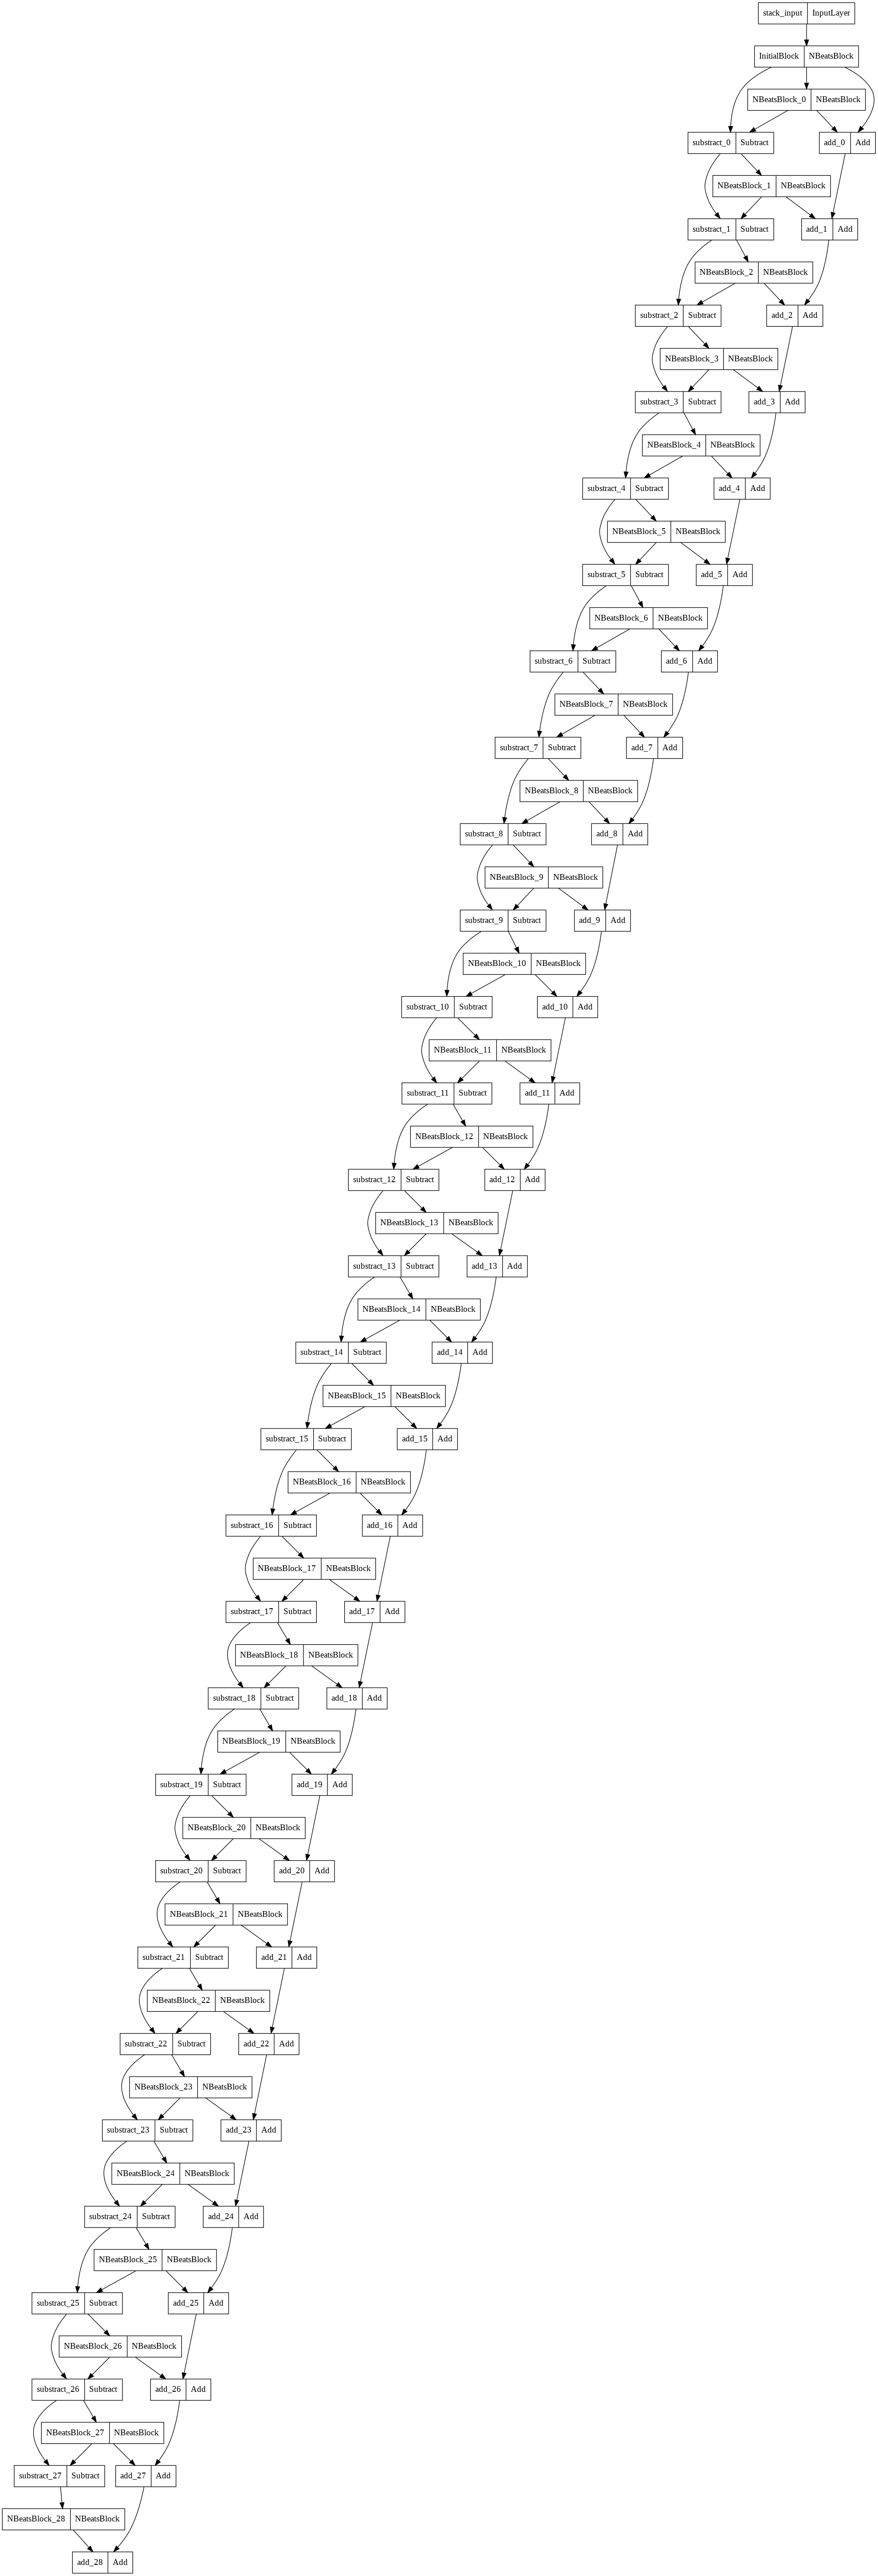

In [121]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

In [122]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=5,
                        num_epochs=1000,
                        loss_fns=["mae","mse","mape"]):
  """
  Returns a list of num_iter models eacg trained on  MAE, MSE, MAPE loss.
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layersnwith normal dictribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile the model
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)
  
  return ensemble_models

     


In [123]:
%%time

#Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)



Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 873: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 973: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 465: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 565: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 277: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 392: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 492: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 521: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 386: ReduceLROnPl

In [124]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [125]:
%%time
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

CPU times: user 561 ms, sys: 27.1 ms, total: 588 ms
Wall time: 599 ms


In [126]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([11948.145, 11464.706, 10293.665, 10383.213, 10215.011, 10294.831,
       10320.984, 10173.487, 10209.105, 10368.713], dtype=float32)>

In [127]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([11943.24 , 11462.947, 10280.952, 10351.919, 10219.225, 10296.377,
       10316.286, 10169.402, 10217.663, 10370.902], dtype=float32)

## Compare preds evaluations

In [128]:
# Evaluate preds
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 1182.2935,
 'mape': 1.0336668,
 'mase': 1.0336668,
 'mse': 2872231.8,
 'rmse': 1694.5676}

In [129]:
# Evaluate preds median
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 1156.3473,
 'mape': 2.8636956,
 'mase': 1.0109823,
 'mse': 2778045.5,
 'rmse': 1666.747}

In [130]:
# Evaluate preds mean
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 1157.0784,
 'mape': 2.8672333,
 'mase': 1.0116215,
 'mse': 2775116.8,
 'rmse': 1665.8682}

In [131]:
model_1_results

{'mae': 1154.8875,
 'mape': 2.8656833,
 'mase': 1.009706,
 'mse': 2796121.8,
 'rmse': 1672.1608}

##  PLotting Prediction intervals

To get the 95% confidense prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly intialized models (previous ensemble models)
2. Measure the standart deviation of the predictions
3. Multiply the standard  deviation by 1.96 (assuming the distribution is Gaussian/Normal. 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the predictions interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1)

* https://en.wikipedia.org/wiki/97.5th_percentile_point
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [132]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds):  # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predcitions
  std = tf.math.reduce_std(preds, axis=0)
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std
  # 4. Get the prediction intevals upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper


In [133]:
# Get the upper and lower bounds of the 95% percent predcitions interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

(<tf.Tensor: shape=(531,), dtype=float32, numpy=
 array([11888.61  , 11326.961 , 10146.132 , 10142.249 , 10098.085 ,
        10095.317 , 10173.018 , 10009.606 , 10104.135 , 10309.291 ,
        10348.736 , 10380.835 , 10310.166 , 10617.367 , 10745.53  ,
        10923.337 , 10894.001 , 10924.118 , 11041.567 , 10874.338 ,
        10362.596 , 10380.175 , 10181.145 , 10603.055 , 10628.15  ,
        10674.727 , 10698.149 , 10667.491 , 10752.554 , 10748.236 ,
        10594.035 , 10520.252 , 10535.814 , 10642.131 , 10750.61  ,
        10570.253 , 10619.848 , 10884.658 , 11020.437 , 11222.168 ,
        11351.414 , 11530.129 , 11400.705 , 11403.324 , 11465.64  ,
        11292.09  , 11307.565 , 11481.154 , 11700.77  , 11852.027 ,
        12648.617 , 12948.869 , 12914.501 , 13062.8955, 12983.146 ,
        12961.624 , 13518.088 , 13239.169 , 13347.363 , 13520.61  ,
        13770.671 , 13634.53  , 13548.279 , 13925.029 , 14107.706 ,
        15346.692 , 15492.203 , 14790.71  , 15244.479 , 15148.234 ,

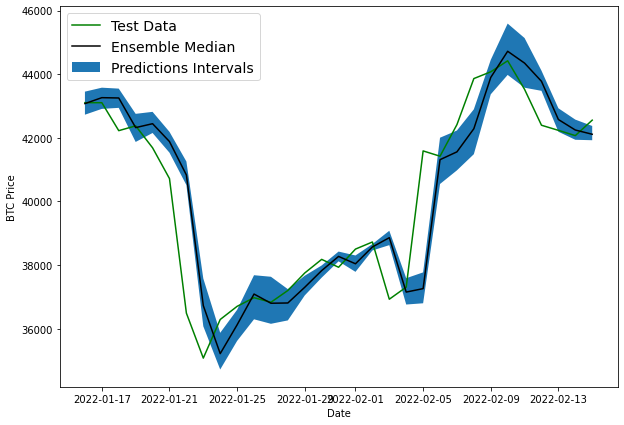

In [134]:
# Get the median/mean values of ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of ensemble preds along with the predictions intervals 
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")

# To plot the upper and lower bounds, use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Predictions Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Train a model on the full historical data to make predictions into the future

In [135]:
HORIZON = 1
WINDOW_SIZE= 7

In [136]:
bitcoin_prices_windowed.head()

,Price,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,,
2014-11-04,324.467934,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,25,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,25,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,25,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,25,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN


In [137]:
# Train model on entire data to make predcitions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"]

len(X_all), len(y_all)

(2654, 2654)

In [138]:
# Turn data into tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [139]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile 
model_9.compile(loss="mae",
              optimizer=tf.keras.optimizers.Adam())

# Fit 
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

## Make predictions into future

In [140]:
# Set global variable

INTO_FUTURE = 14

# To make predictions into future function must to:

1. Take a input:
  * a list of values (Bitcoin historical data)
  * a trained model(such as 'model_9')
  * a window into the future to predict ('INTO_FUTURE' variable)
  * the window size a model was trained on ('WINDOW_SIZE')
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions)
    and extracts the last 'WINDOW_SIZE' values from the input values.
3. Loop 'INTO_FUTURE' times making a predictions on 'WINDOW_SIZE' sequences which update to remove the first value and append the latest predcitions

In [141]:
# 1. Create function to make predictions into teh future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Reutrns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecasts on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]
  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(into_future):
    # Predict on the last window then append it again and again
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # Update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [142]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

Predicting on:
 Date
2022-02-09    44074.346549
2022-02-10    44421.009164
2022-02-11    43522.241370
2022-02-12    42394.145450
2022-02-13    42233.713050
2022-02-14    42067.755487
2022-02-15    42554.261521
Name: Price, dtype: float64 -> Prediction: 44105.09375

Predicting on:
 [44421.009164 43522.24137  42394.14545  42233.71305  42067.755487
 42554.261521 44105.09375 ] -> Prediction: 43698.77734375

Predicting on:
 [43522.24137    42394.14545    42233.71305    42067.755487
 42554.261521   44105.09375    43698.77734375] -> Prediction: 42809.5

Predicting on:
 [42394.14545    42233.71305    42067.755487   42554.261521
 44105.09375    43698.77734375 42809.5       ] -> Prediction: 42199.75390625

Predicting on:
 [42233.71305    42067.755487   42554.261521   44105.09375
 43698.77734375 42809.5        42199.75390625] -> Prediction: 42354.859375

Predicting on:
 [42067.755487   42554.261521   44105.09375    43698.77734375
 42809.5        42199.75390625 42354.859375  ] -> Prediction: 42471

## Plot future forecast

In [143]:
def  get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging  from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date "D" - Day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [144]:
# Last timestep of timesteps from DataFrame
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2022-02-15 00:00:00')

In [145]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19',
       '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
       '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27',
       '2022-02-28', '2022-03-01'], dtype='datetime64[D]')

In [146]:
# Insert last timestep/final price into next time steps and future forecasts to put into correct form
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
        '2022-02-19', '2022-02-20', '2022-02-21', '2022-02-22',
        '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26',
        '2022-02-27', '2022-02-28', '2022-03-01'], dtype='datetime64[D]'),
 array([42554.26 , 44105.094, 43698.777, 42809.5  , 42199.754, 42354.86 ,
        42471.043, 43272.176, 43689.71 , 43087.4  , 42421.98 , 42316.344,
        42555.887, 42889.387, 43345.004], dtype=float32))

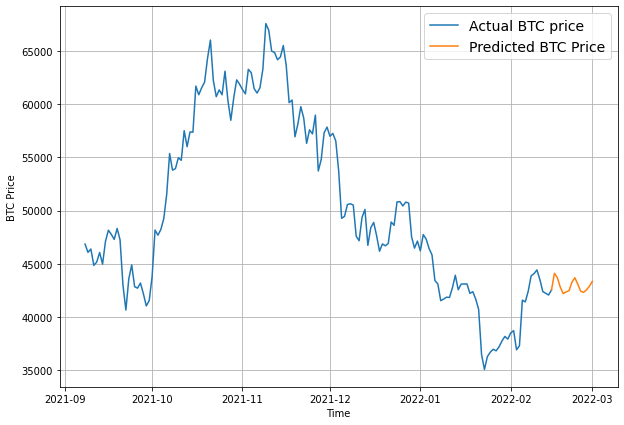

In [147]:
# PLot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10 : Why forecasting is BS (unpredictable)

In [148]:
#  Introduce a BS problem to BTC data
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [151]:
# Manufacture an extra price on the end 
btc_price_turkey[-10:]

[41420.436241,
 42414.080523,
 43861.85,
 44074.346549,
 44421.009164,
 43522.24137,
 42394.14545,
 42233.71305,
 42067.755487,
 42554.261521]

In [152]:
# Get the timesteps for the BS problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2022-02-06T00:00:00.000000000', '2022-02-07T00:00:00.000000000',
       '2022-02-08T00:00:00.000000000', '2022-02-09T00:00:00.000000000',
       '2022-02-10T00:00:00.000000000', '2022-02-11T00:00:00.000000000',
       '2022-02-12T00:00:00.000000000', '2022-02-13T00:00:00.000000000',
       '2022-02-14T00:00:00.000000000', '2022-02-15T00:00:00.000000000'],
      dtype='datetime64[ns]')